In [41]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import LinearSVR
#import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import pickle
import json
#import seaborn as sns
import matplotlib.pyplot as plt

# I. Traitement des données

In [42]:
#chargement des données
data = pd.read_csv('data_exported.csv')

In [43]:
#1) on sélectionne nos colonnes utiles :
haut_tot = data[["haut_tot"]]
haut_tronc = data[["haut_tronc"]]
diam_tronc = data[["tronc_diam"]]
age_estim = data[["age_estim"]]
stade_dev = data[["fk_stadedev"]]

#### a) encoding : 

In [44]:
# on ecode la colonne "fk_stadedev" car c'est une colonne catégorielle
X1 = pd.concat([haut_tot, haut_tronc, diam_tronc, stade_dev], axis=1)
encoding = OrdinalEncoder()
X1['fk_stadedev'] = encoding.fit_transform(stade_dev)

#### b) normalisation : 

In [45]:
Y = age_estim
scaler_X = StandardScaler()  #un scaler pour X et un scaler pour Y l'enregistrement des modèles de prétraitement des données
scaler_Y = StandardScaler()

In [46]:
#3) normalisation des données :
X1 = pd.DataFrame(scaler_X.fit_transform(X1), columns=X1.columns)
Y = scaler_Y.fit_transform(Y.values.reshape(-1, 1)).ravel()

#### c) matrice de corrélation

             haut_tot  haut_tronc  tronc_diam  fk_stadedev  age_estim
haut_tot     1.000000    0.508100    0.683122    -0.051692   0.488747
haut_tronc   0.508100    1.000000    0.375107     0.021338   0.493529
tronc_diam   0.683122    0.375107    1.000000    -0.111777   0.595744
fk_stadedev -0.051692    0.021338   -0.111777     1.000000  -0.033328
age_estim    0.488747    0.493529    0.595744    -0.033328   1.000000


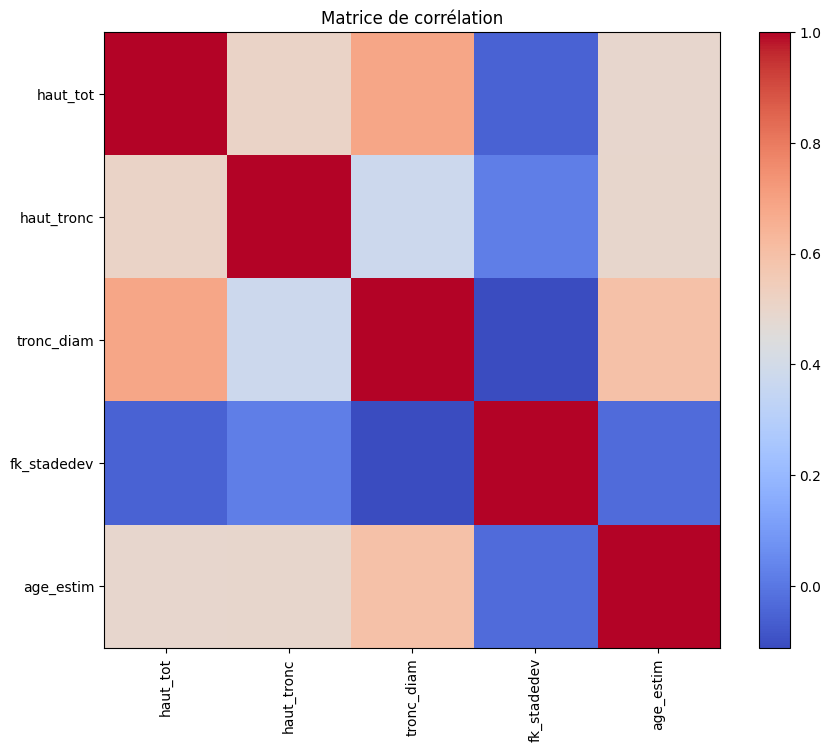

In [47]:
df_matrice_corr = pd.concat([haut_tot, haut_tronc, diam_tronc, X1['fk_stadedev'], age_estim], axis=1)

# matrice de corrélation
correlation_matrix = df_matrice_corr.corr()
print(correlation_matrix)

plt.figure(figsize=(10, 8))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.title('Matrice de corrélation')
plt.colorbar()
tick_marks = [i for i in range(len(correlation_matrix.columns))]
plt.xticks(tick_marks, correlation_matrix.columns, rotation='vertical')
plt.yticks(tick_marks, correlation_matrix.columns)
plt.show()

#### d) création de la databse de frame et séparation des données 

In [48]:
#on prends tous les indices du dataset
indices = np.arange(data.shape[0])
# division des données en ensembles d'entraînement et de test (les x et y pour l'apprentissage et test_indice pour la dataframe de test)
x_train, x_test, y_train, y_test, train_indice, test_indice = train_test_split(X1, Y, indices, train_size=0.80, test_size=0.20)

other_data2 = pd.read_csv('data_exported.csv')
test_data = other_data2.iloc[test_indice]  #on récupère que les lignes concernées par les indices de test

#on renvoie le fichier sous format JSON, et 'record' c'est pour mettre le nom des colonnes dans la dataframe
test_data.to_json("df_test.json", orient='records')

# II. Entrainement, métriques et GridSearchCV : 

## 1) Pour le RandomForestRegressor :

##### a) Entrainement

In [49]:
RFG = RandomForestRegressor(random_state=42)
RFG.fit(x_train, y_train)
prediction = RFG.predict(x_test)

##### b) études des métriques

In [50]:
# on va étudier les performances des modèles :
##accuracy 1 :
accuracy = r2_score(y_test, prediction)
print("accuracy random forest: ", accuracy)

##accuracy 2 :
other_accuracy = np.mean(cross_val_score(RFG, x_test, prediction))   #autre moyen de déterminer l'accuracy du classifieur
print("corss val random forest :", other_accuracy)

##rmse :
squared_error = mean_squared_error(y_test, prediction)
rmse = np.sqrt(squared_error)
print("rmse random forest : ", rmse)

## mae :
mae = mean_absolute_error(y_test, prediction)
print("mae random forest : ", mae)

accuracy random forest:  0.6901443312004352
corss val random forest : 0.9008436476463842
rmse random forest :  0.5410715755163857
mae random forest :  0.3345361701035678


##### c) GridSearchCV

In [51]:
param1 = { 'n_estimators' : [100, 250],
               'max_features' : [1, 0.5, 0.2],
               'max_depth' : [50, 100, 150, 250],
          'n_jobs' : [1, 2, 3, 4]}

clf1 = GridSearchCV(RFG, param1, cv=5)
clf1.fit(x_train, y_train)
score1 = r2_score(y_test, clf1.predict(x_test))  #montre la précision de prédiction du modèle
print ("Score final : ", score1, " %")
print ("Meilleurs parametres: ", clf1.best_params_)   #montre les meilleurs paramètres
print ("Meilleure config: ", clf1.best_estimator_)   #prends le meilleurs fit du classifieurs

Score final :  0.6918147521352673  %
Meilleurs parametres:  {'max_depth': 50, 'max_features': 1, 'n_estimators': 250, 'n_jobs': 1}
Meilleure config:  RandomForestRegressor(max_depth=50, max_features=1, n_estimators=250, n_jobs=1,
                      random_state=42)


## 2) Pour le DecisionTreeRegressor :

##### a) entrainement

In [52]:
DTR = DecisionTreeRegressor(random_state=42)
DTR.fit(x_train, y_train)
prediction2 = DTR.predict(x_test)

##### b) études des métriques

In [53]:
##accuracy 1 :
accuracy2 = r2_score(y_test, prediction2)
print("accuracy model 2 : ", accuracy2)

##accuracy 2 :
other_accuracy2 = np.mean(cross_val_score(DTR, x_test, prediction2))
print("cross val model 2 :", other_accuracy2)

##rmse :
squared_error2 = mean_squared_error(y_test, prediction2)
rmse2 = np.sqrt(squared_error2)
print("rmse model 2 :", rmse2)

## mae :
mae2 = mean_absolute_error(y_test, prediction2)
print("mae model 2 :", mae2)

accuracy model 2 :  0.583908899812579
cross val model 2 : 0.6147163541852151
rmse model 2 : 0.6270024095654632
mae model 2 : 0.3508407637690182


##### c) GridSearchCV

In [54]:
param2 = { 'min_samples_split' : [2, 5, 7],
               'max_features' : [1, 0.5, 2],
               'max_depth' : [50, 100],
          'criterion' : ["squared_error", "friedman_mse", "absolute_error"]}

clf2 = GridSearchCV(DTR, param2, cv=5)
clf2.fit(x_train, y_train)
score2 = r2_score(y_test, clf2.predict(x_test))
print ("Score final : ", score2 , " %")
print ("Meilleurs parametres: ", clf2.best_params_)
print ("Meilleure config: ", clf2.best_estimator_)

Score final :  0.5981814457927606  %
Meilleurs parametres:  {'criterion': 'friedman_mse', 'max_depth': 50, 'max_features': 0.5, 'min_samples_split': 7}
Meilleure config:  DecisionTreeRegressor(criterion='friedman_mse', max_depth=50, max_features=0.5,
                      min_samples_split=7, random_state=42)


## 3) Pour le SGDRegressor :

##### a) entrainement : 

In [55]:
SGD = SGDRegressor(random_state=42)
SGD.fit(x_train, y_train)
prediction3 = SGD.predict(x_test)

##### b) études des métriques

In [56]:
##accuracy 1 :
accuracy3 = r2_score(y_test, prediction3)
print("accuracy model 3 : ", accuracy3)

##accuracy 2 :
other_accuracy3 = np.mean(cross_val_score(SGD, x_test, prediction3))
print("cross val model 3 :", other_accuracy3)

##rmse :
squared_error3 = mean_squared_error(y_test, prediction3)
rmse3 = np.sqrt(squared_error3)
print("rmse model 3 : ", rmse3)

## mae :
mae3 = mean_absolute_error(y_test, prediction3)
print("mae model 3 :", mae3)

accuracy model 3 :  0.47416790972671774
cross val model 3 : 0.999993834351087
rmse model 3 :  0.704852979221662
mae model 3 : 0.5133282327862263


##### c) GridSearchCV

In [57]:
param3 = { 'alpha' : [0.001, 0.05, 0.5],
               'max_iter' : [800, 1000, 1200],
               'epsilon' : [0.1, 0.5, 0.9]}

clf3 = GridSearchCV(SGD, param3, cv=5)
clf3.fit(x_train, y_train)
score3 = r2_score(y_test, clf3.predict(x_test))
print ("Score final : ", score3 , " %")
print ("Meilleurs parametres: ", clf3.best_params_)
print ("Meilleure config: ", clf3.best_estimator_)

Score final :  0.4742099864733835  %
Meilleurs parametres:  {'alpha': 0.001, 'epsilon': 0.1, 'max_iter': 800}
Meilleure config:  SGDRegressor(alpha=0.001, max_iter=800, random_state=42)


## 4) Pour le LinearSVR : 

##### a) entrainement

In [58]:
L_SVR = LinearSVR(random_state=42, dual = True)
L_SVR.fit(x_train, y_train)
prediction4 = L_SVR.predict(x_test)

##### b) études des métriques

In [59]:
##accuracy 1 :
accuracy4 = r2_score(y_test, prediction4)
print("accuracy model 4 :", accuracy4)

##accuracy 2 :
other_accuracy4 = np.mean(cross_val_score(L_SVR , x_test, prediction4))
print("cross val model 4 :", other_accuracy4)

##rmse :
squared_error4 = mean_squared_error(y_test, prediction4)
rmse4 = np.sqrt(squared_error4)
print("rmse model 4 :", rmse4)

## mae :
mae4 = mean_absolute_error(y_test, prediction4)
print("mae model 4 :", mae4)

accuracy model 4 : 0.409232021707729
cross val model 4 : 1.0
rmse model 4 : 0.7471081429786934
mae model 4 : 0.47182935749063565


##### c) GridSearchCV

In [60]:
param4 = {
    'C': [0.1, 1, 10],
    'epsilon': [0.01, 0.1, 1],
    'max_iter': [10000, 20000]
}

clf4 = GridSearchCV(L_SVR, param4, cv=5, scoring='r2', n_jobs=-1)
clf4.fit(x_train, y_train)
score4 = r2_score(y_test, clf4.predict(x_test))
print ("Score final : ", score4, " %")
print ("Meilleurs parametres: ", clf4.best_params_)
print ("Meilleure config: ", clf4.best_estimator_)

Score final :  0.4088547964550825  %
Meilleurs parametres:  {'C': 1, 'epsilon': 1, 'max_iter': 10000}
Meilleure config:  LinearSVR(C=1, dual=True, epsilon=1, max_iter=10000, random_state=42)


## 5) Pour le MLPRegressor : 

##### a) entrainement 

In [61]:
MPLR = MLPRegressor(hidden_layer_sizes=(100, 100, 100), random_state=42, max_iter = 1000)
MPLR.fit(x_train, y_train)
prediction5 = MPLR.predict(x_test)

##### b) étude des métriques

In [62]:
## accuracy 1 :
accuracy5 = r2_score(y_test, prediction5)
print("accuracy model 5 :", accuracy5)

## accuracy 2 :
other_accuracy5 = np.mean(cross_val_score(MPLR, x_test, prediction5))
print("cross val model 5 :", other_accuracy5)

##rmse :
squared_error5 = mean_squared_error(y_test, prediction5)
rmse5 = np.sqrt(squared_error5)
print("rmse model 5 :", rmse5)

## mae :
mae5 = mean_absolute_error(y_test, prediction5)
print("mae model 5 :", mae5)

accuracy model 5 : 0.6834255250086991
cross val model 5 : 0.9549591160774034
rmse model 5 : 0.5469063225755734
mae model 5 : 0.34782073114764567


##### c) GridSearchCV

In [63]:
param5 = {
    'activation': ["relu"],
    'solver': ["adam"],
    'learning_rate': ['constant'],

}
clf5 = GridSearchCV(MPLR, param5, cv=5)
clf5.fit(x_train, y_train)
score5 = r2_score(y_test, clf5.predict(x_test))
print ("Score final : ", score5, " %")
print ("Meilleurs parametres: ", clf5.best_params_)
print ("Meilleure config: ", clf5.best_estimator_)

Score final :  0.6834255250086991  %
Meilleurs parametres:  {'activation': 'relu', 'learning_rate': 'constant', 'solver': 'adam'}
Meilleure config:  MLPRegressor(hidden_layer_sizes=(100, 100, 100), max_iter=1000, random_state=42)


## Présentation et comparaison des résultats des métriques : 

In [64]:
results = {  #on met tout nos résultats dans un dictionnaire pour en faire la comparaison en fonction des modèles
    "Modèle": ["Random Forest", "Decision Tree", "SGD Regressor", "Linear SVR", "MLP Regressor"],
    "R²": [accuracy, accuracy2, accuracy3, accuracy4, accuracy5],
    "RMSE": [rmse, rmse2, rmse3, rmse4, rmse5],
    "MAE": [mae, mae2, mae3, mae4, mae5],
    "Cross_val_score_moyen" : [other_accuracy, other_accuracy2, other_accuracy3, other_accuracy4, other_accuracy5],
    "GridSearchCV scores" : [score1, score2, score3, score4, score5]
}

results_df = pd.DataFrame(results)
print(results_df)

          Modèle        R²      RMSE       MAE  Cross_val_score_moyen  \
0  Random Forest  0.690144  0.541072  0.334536               0.900844   
1  Decision Tree  0.583909  0.627002  0.350841               0.614716   
2  SGD Regressor  0.474168  0.704853  0.513328               0.999994   
3     Linear SVR  0.409232  0.747108  0.471829               1.000000   
4  MLP Regressor  0.683426  0.546906  0.347821               0.954959   

   GridSearchCV scores  
0             0.691815  
1             0.598181  
2             0.474210  
3             0.408855  
4             0.683426  


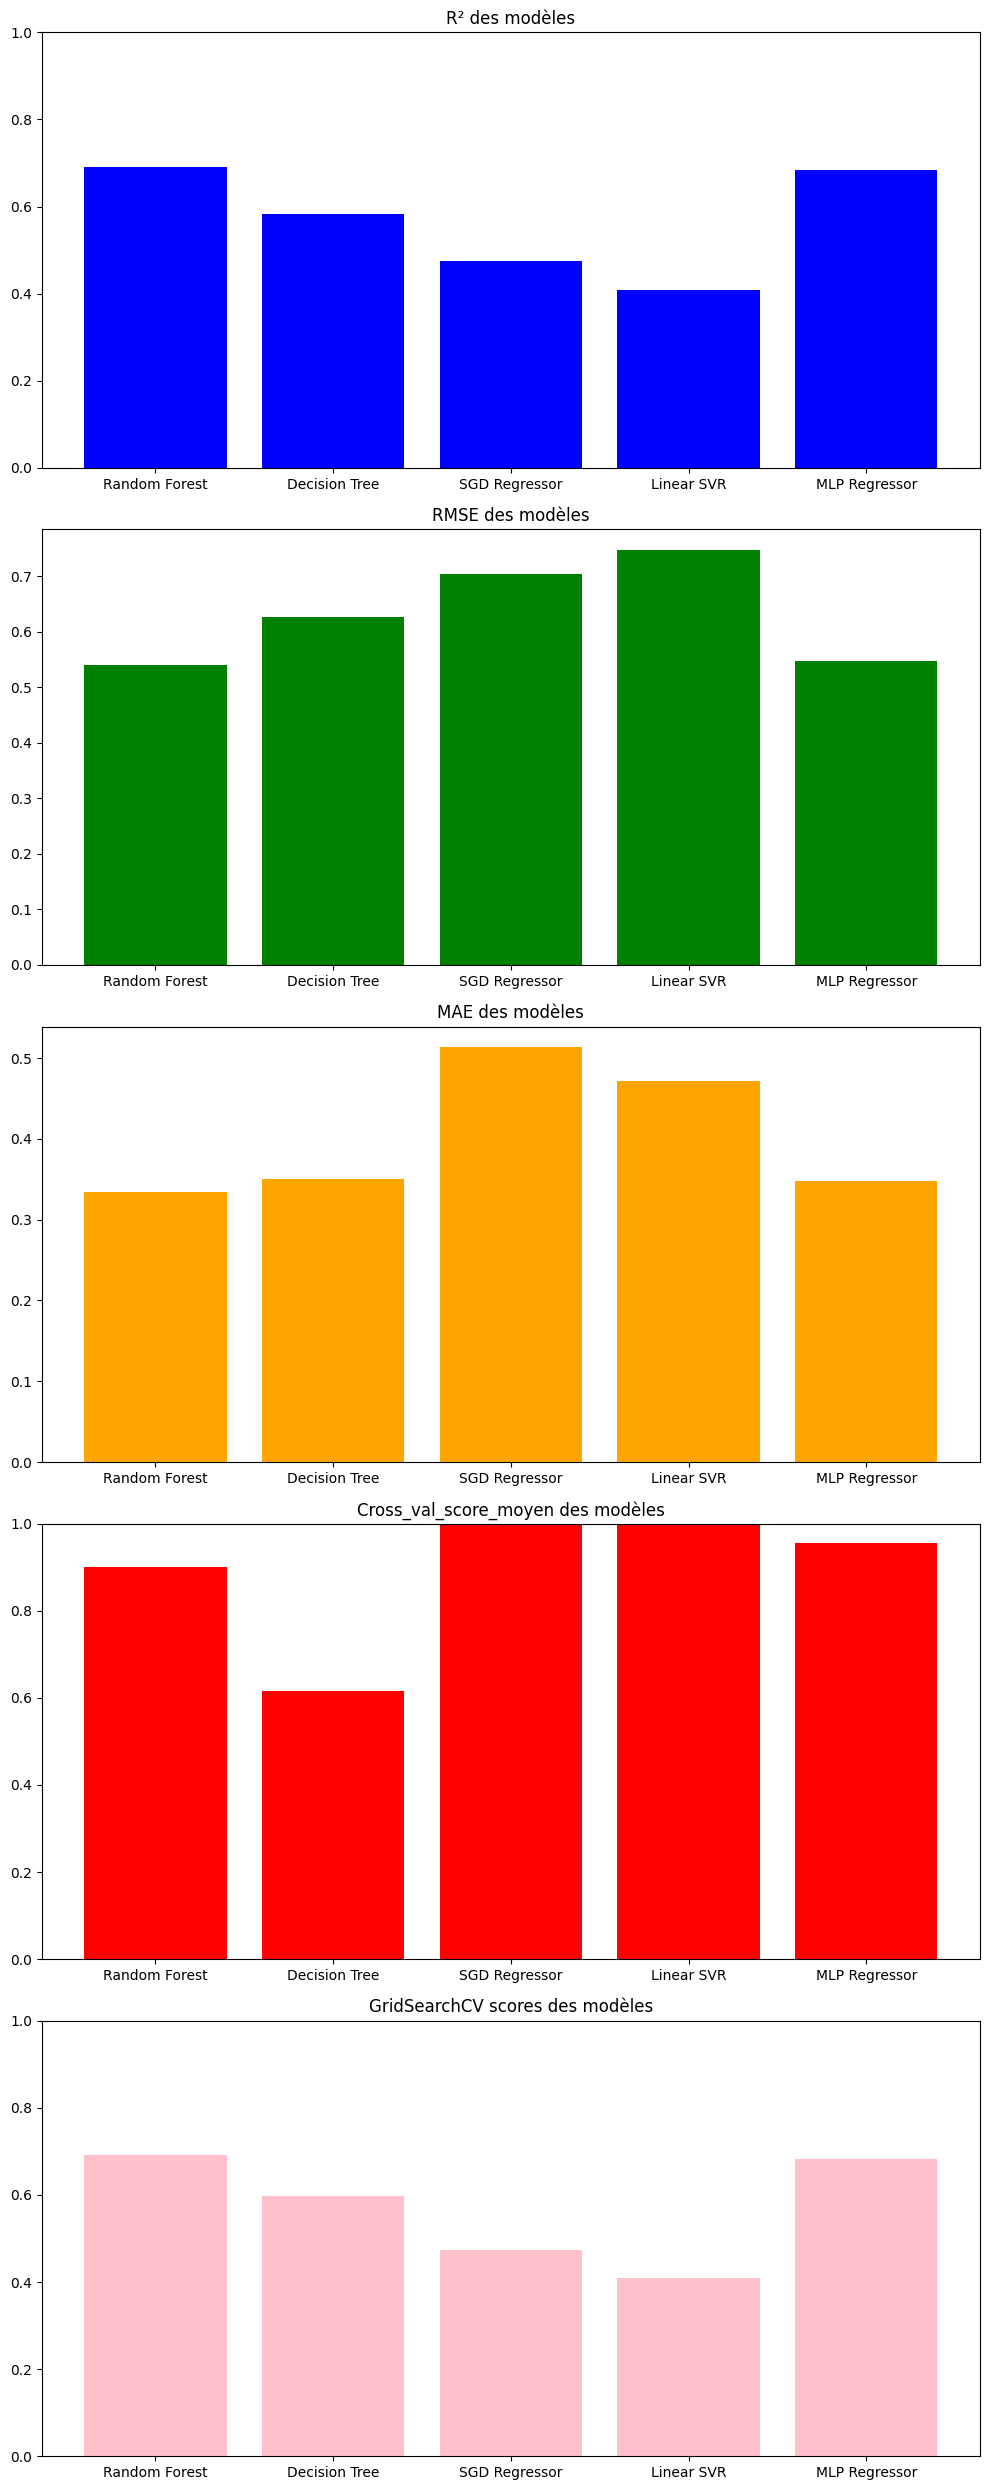

In [65]:
# représentation graphique des performances
fig2, axs = plt.subplots(5, 1, figsize=(10, 25))

axs[0].bar(results_df["Modèle"], results_df["R²"], color='blue')
axs[0].set_title('R² des modèles')
axs[0].set_ylim(0, 1)

axs[1].bar(results_df["Modèle"], results_df["RMSE"], color='green')
axs[1].set_title('RMSE des modèles')

axs[2].bar(results_df["Modèle"], results_df["MAE"], color='orange')
axs[2].set_title('MAE des modèles')

axs[3].bar(results_df["Modèle"], results_df["Cross_val_score_moyen"], color='red')
axs[3].set_title('Cross_val_score_moyen des modèles')
axs[3].set_ylim(0, 1)

axs[4].bar(results_df["Modèle"], results_df["GridSearchCV scores"], color='pink')
axs[4].set_title('GridSearchCV scores des modèles')
axs[4].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# III. Sauvegarde de l'entrainement du modèle le plus performant : 

In [66]:
def sauv_model(model, params, x_train, y_train):
    """
    fonction qui va prendre la meilleurs combinaison d'entrainement avec le GridSearchCV puis on va s'y faire entrainer le modèle et garder
    cet entrainement
    :param model:
    :param params:
    :param x_train:
    :param y_train:
    :return: l'entrainement du modèle le plus performant
    """
    clf = GridSearchCV(model, params, cv=5)
    clf.fit(x_train, y_train)
    return clf.best_estimator_

model_class = {"RandomForestRegressor" : []}

param1 = { 'n_estimators' : [100, 250],
               'max_features' : [1, 0.5, 0.2],
               'max_depth' : [50, 100, 150, 250],
          'n_jobs' : [1, 2, 3, 4]}

model_class['RandomForestRegressor'] = sauv_model(RandomForestRegressor(random_state=42), param1, x_train, y_train)

In [67]:
enregistrement = {  #on mets nos modèles de prétraitement et notre modèle d'entrainement dans un dictionnaire
    'pretraitement': {'encoding': encoding},
    'scaler_X': scaler_X,
    'scaler_Y': scaler_Y,
    'models': model_class
}

In [68]:
# on enregistre le dictionnaire qu'on envoie en format pkl pour le script
with open('enregistrement.pkl', 'wb') as f:
    pickle.dump(enregistrement, f)


print(enregistrement)

{'pretraitement': {'encoding': OrdinalEncoder()}, 'scaler_X': StandardScaler(), 'scaler_Y': StandardScaler(), 'models': {'RandomForestRegressor': RandomForestRegressor(max_depth=50, max_features=1, n_estimators=250, n_jobs=1,
                      random_state=42)}}
